In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from sklearn.utils import resample
# From ss we use ss.kstest() for Komogorov Smirnov and ss.cramervonmises_2samp(x, y) for the two sample comparison using Cramer-von Mises
# The ss.bootstrap() function works great if you want to do a traditional bootstrap, where you draw from your sample of N data points 
# N random data points with replacement; however we aim to sub-sample. 
import statsmodels.api as sm # Import for autocorrelation estimate and plot using sm.graphics.tsa.plot_acf

# Plot imports and parameters 
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 15}
matplotlib.rc('font', **font)

## Purpose
This notebook is for help with comparing distributions of data, with special attention to MD datasets. The Kolmogorov Smirnov (KS) test and Cramer-von Mises (CvM) tests are used. The KS test is non-parameteric, which makes it particularly useful for data where the underlying distribution is not known. 

### References
[1] Zeimbekakis, A., Schifano, E. D., & Yan, J. (2024). On Misuses of the Kolmogorov–Smirnov Test for One-Sample Goodness-of-Fit. The American Statistician, 78(4), 481-487.
https://www.tandfonline.com/doi/full/10.1080/00031305.2024.2356095 \
[2] Büning, H. (2002). Robustness and power of modified Lepage, Kolmogorov-Smirnov and Crame´ r-von Mises two-sample tests. Journal of Applied Statistics, 29(6), 907-924.
https://www.tandfonline.com/doi/abs/10.1080/02664760220136212 \
[3] Chen, O. Y., Bodelet, J. S., Saraiva, R. G., Phan, H., Di, J., Nagels, G., ... & De Vos, M. (2023). The roles, challenges, and merits of the p value. Patterns, 4(12). 
https://www.sciencedirect.com/science/article/pii/S2666389923002702

### Tutorials
1. How the KS test looks for differences between two distriubtions: \
https://towardsdatascience.com/understanding-kolmogorov-smirnov-ks-tests-for-data-drift-on-profiled-data-5c8317796f78/
2. Dealing with auto-correlated data (MD data often is): \
   https://engineering.atspotify.com/2023/09/how-to-accurately-test-significance-with-difference-in-difference-models
3. Potential pitfalls of the K-S test! \
   https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.
5. Why Anderson Darling may be better, and a concise explanation of K-S's strengths and limitations: \
https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.
6. Explaining reference [1]: \
https://www.reddit.com/r/statistics/comments/7j273q/still_dont_understand_why_the_pvalue_distribution/
7. Explaining uniform distribution of p-values: \
https://www.reddit.com/r/statistics/comments/7j273q/still_dont_understand_why_the_pvalue_distribution/ 

## Common pitfalls for the Kolmogorov-Smirnov test
* Data must be continuous [1] (consider if Chi-square Test if data is categorical)
    - Rounding continuous data can invalidate the test
    - "Ties", where two data points have the same value indicate that the underlying data generator does not create continuous data
* When comparing your distribution to another distribution (e.g. to see if your data is normal), your independent distribution should not be created using the mean and standard deviation of your dataset, but should be independent.
    - See tutorial explaining reference 1.
* Data should be independent (this is a major problem for MD data, which is usually from a time series and autocorrelated. Autocorrelation means that the data at time x-i has some predicitive value for the data at time x, which for a protein moving in time is true -- as i goes to zero, the position at time x-i approaches the position at time x. Since the test assumes independence, autocorrelation contributes to an over-estimation of significance, along with the overpowering from excessive sampling). For more on methods to deal with this, see tutorial 2.

## Special considerations
* Consider using Anderson-Darling if the important differences between the distributions are in the tails. (https://asaip.psu.edu/articles/beware-the-kolmogorov-smirnov-test/#:~:text=We%20recommend%20that%20the%20distribution%20of%20the,KS%20test%20in%20two%20or%20more%20dimensions.)
* The CvM test also looks more holistically at the whole distribution, whereas the KS test looks only at the maximum difference in the cumulative distribution function (CDF).

# So what do we do. 

According to the blog post in tutorial [3], and as suggested in reference [3] bootstrapping can be an advisable technique. Nonetheless, there is mixed consensus sincce it is entirely unclear what the sample size should be. There is good consensus that effect sizes and confidence intervals yield more insight about the data than using a p-value alone (see ref [3]). At all times, it is important to keep in mind that statistics are more a way to characterize the data rather than to prove a claim. My recommendation is that when comparing distribution we focus less on a claim of "statistically significantly different" and add context using plots like those in this notebook and descriptions like "For a 1,000 sample permutation bootstrap with sample size X, the 95% confidence interval for p-values was 0.06."

It is ambiguous if bootstrapping might be helpful in resolving the auto-correlation issue for MD data. My thought right now is maybe the raw data needs to be analyzed for an autocorrelateion period, and that the sample size should be based on sampling roughly one sample per period. Arguably, this would result in lots of instances where a sinlge period is sampled multiple times, so there would be auto-correlations still, but at the same time it's the only reason I can conjure to justify a given sample size. That said, there was not a clear fall off below 50% autocorrelation for my test data -- this may differ for a given dataset, and it is potentially worth examining the autocorrelation. 

Ultimately, the largest argument against bootstrapping seems to be that there's not a "correct" way to determine sample sizes. But, arguably, the whole sample size is not necessarily "correct" either; and on that note, the choice of test is not necessarily a matter of "correct-ness." The core idea is that we'd like to use statistics to convey to the reader the importance of the data. Doing a small parameter sweep on sample size may provide a more comprehensive description of the data. Ultimately, we will often fall bias to choosing to present the data using the plot we like the best, which is always a challenge, but one that we're perhaps more aware of by digging more deeply into the underlying statistics.  

There seems to be no reason to not use either A-D or Cramer-von Mises in place of K-S. The reason that C-M may be preferable is it normalizes across the whole distribution rather than relying on the maximum alone. Any of these can be reweighted in order to emphasize the underlying upper/lower distributions. 

It may be worthwhile to bootstrap on Z and look at distribution of P values. It should be linear, flat. And then to bootstrap for X and Y -- it should be non-linear.

Mutation: WT


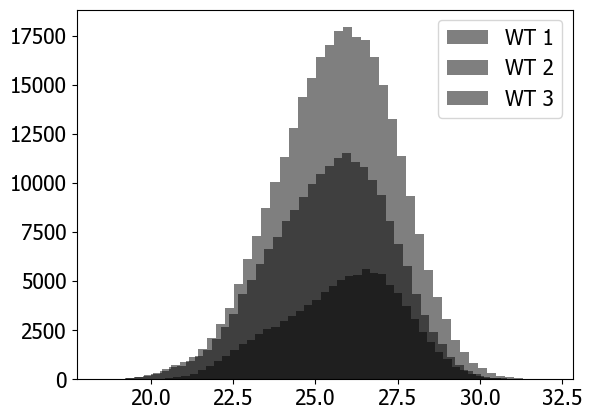

Mutation: P210S


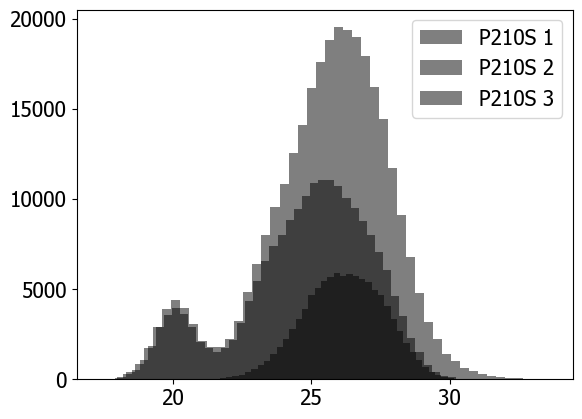

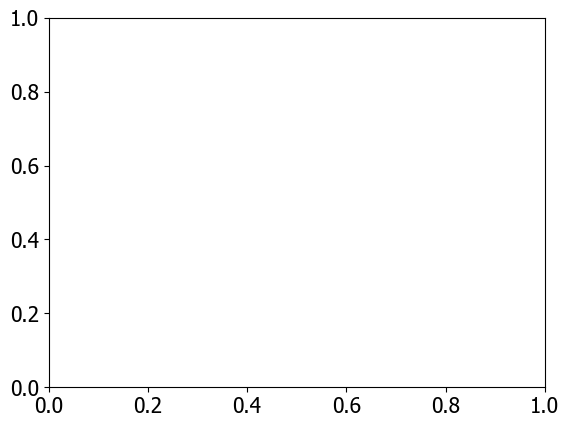

In [2]:
# As an example, let's compare the distributions of groove width from WT and P210S data. 
# To mimic actual data better, we'll use all three replicates -- this adds to the challenge
# because replicates may sample different behavior, especially with intrinsically disordered regions

muts = ['WT','P210S']
reps = ['1','2','3']
combined_data = {'WT':[],'P210S':[]}
for mut in muts:
    temp = []
    for rep in reps:
        path = 'exampleData/'+mut+'_lig/MRPP2_'+rep+'_helices_distance.dat'
        df = pd.read_table(path, sep=r"\s+")
        temp.append(df.side1.values)
        temp.append(df.side2.values)

        # View the distributions of each replicate individually. Observe that for this dataset, P210S 1 has a different character than P210S 2 and P210S 3. 
        plt.hist(np.concatenate(np.array(temp)), bins = 50, alpha = .5, color = 'black', label = mut + ' ' + rep)
        plt.legend()
        
        # Uncomment both of these if aiming to view plots for each replicate individually
        #plt.show()
        #plt.cla()
    
    temp = np.concatenate(np.array(temp))
    combined_data[mut] = temp
    print("Mutation: " + mut)
    plt.show()
    plt.cla()


In [3]:
# To make this notebook more easily adapted to user data, the two distributions to compare are x and y, and the distribution formed by the union of x and y is z. 
x = combined_data['WT']
y = combined_data['P210S']
z = np.concatenate((combined_data['WT'],combined_data['P210S']))

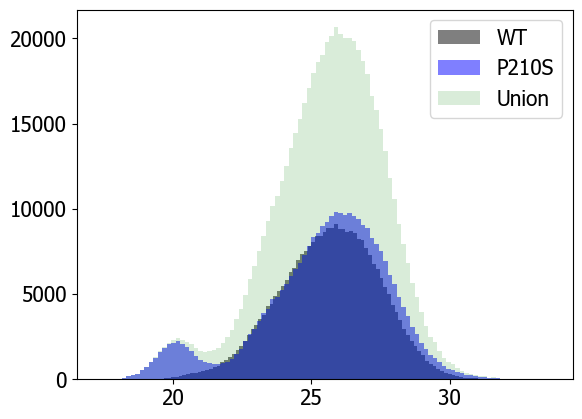

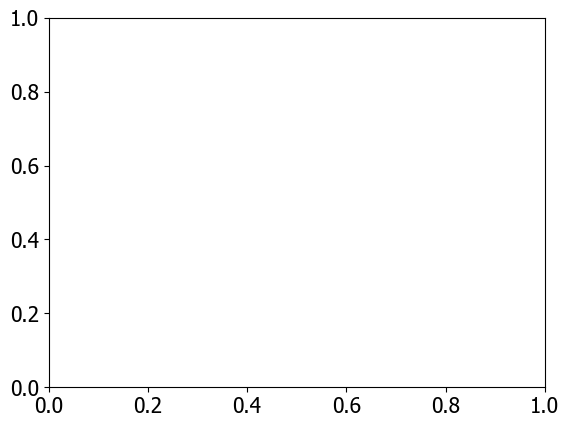

In [33]:
plt.hist(x, bins = 100, alpha = .5, color = 'black', label = 'WT')
plt.hist(y, bins = 100, alpha = .5, color = 'blue', label = 'P210S')
plt.hist(z, bins = 100, alpha = .15, color = 'green', label = 'Union')
plt.legend()
plt.show()
plt.cla()

In [34]:
# Run a permutation bootstrap; we did not use ss.bootstrap because it does not support subsampling -- subsampling is necessary because 1) my kernel crashes using
# the full data sample size and 2) conceptually we are trying to unbiase our results from massive over sampling.
n_resamples = 100 # number of times to randomly sub-sample -- 1,000 is a recommended MINIMUM for bootstrapping; but for testing the code try a smaller number for faster runs
fraction = 3000
n = int(len(combined_data['P210S'])/fraction) # sample size of each random draw from the underlying distribution
print("Sample size is: " + str(n))

# Predetermine size of dataframe and insert values to speed up computation instead of appending to empty arrays
column_names = ['cvm_pvals', 'cvm_stats', 'ks_pvals', 'ks_stats', 'cvm_z_pvals', 'cvm_z_stats', 'ks_z_pvals', 'ks_z_stats']
df = pd.DataFrame(index=range(n_resamples), columns=column_names)

for i in np.arange(0,n_resamples):
    boot_x = resample(x, replace=True, n_samples=n)
    boot_y = resample(y, replace=True, n_samples=n)

    cvm_res = ss.cramervonmises_2samp(boot_x, boot_y)
    df.loc[i, 'cvm_pvals'] = cvm_res.pvalue
    df.loc[i, 'cvm_stats'] = cvm_res.statistic

    ks_res = ss.kstest(boot_x, boot_y)
    df.loc[i, 'ks_pvals'] = ks_res.pvalue
    df.loc[i, 'ks_stats'] = ks_res.statistic


    # Compare the actual test statistic for samples compared from the x and y distributions, and from random sampling of z (where z is the union of x & y)
    # When comparing two samples from z, they are both drawn from the same underlying distribution (e.g. we know that the null hypothesis should hold). 
    # This allows us to understand how random subsampling of the data impacts our conclusion. 
    boot_zx = resample(z, replace=True, n_samples=n)
    boot_zy = resample(z, replace=True, n_samples=n)

    cvm_z_res = ss.cramervonmises_2samp(boot_zx, boot_zy)
    df.loc[i, 'cvm_z_pvals'] = cvm_z_res.pvalue
    df.loc[i, 'cvm_z_stats'] = cvm_z_res.statistic
    
    ks_res = ss.kstest(boot_zx, boot_zy)
    df.loc[i, 'ks_z_pvals'] = ks_res.pvalue
    df.loc[i, 'ks_z_stats'] = ks_res.statistic


Sample size is: 100


KstestResult(statistic=0.08, pvalue=0.9084105017744525, statistic_location=22.5298, statistic_sign=-1)
CramerVonMisesResult(statistic=0.06682499999999436, pvalue=0.7779636930955319)


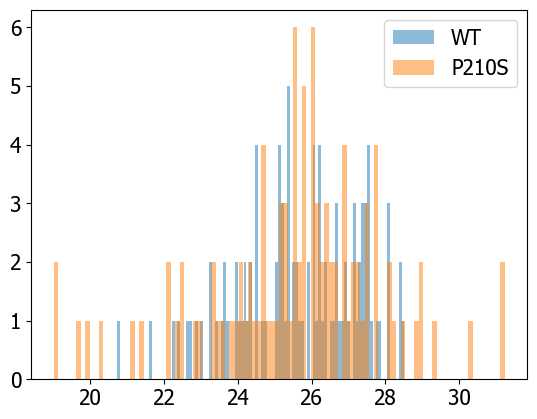

In [35]:
# Example comparison of the distributions from two bootstraps and the results of the KS and CvM tests for these bootstraps
plt.hist(boot_x, bins = 100, alpha = .5, label = 'WT')
plt.hist(boot_y, bins = 100, alpha = .5, label = 'P210S')
plt.legend()
print(ss.kstest(boot_x, boot_y))
print(ss.cramervonmises_2samp(boot_x, boot_y))

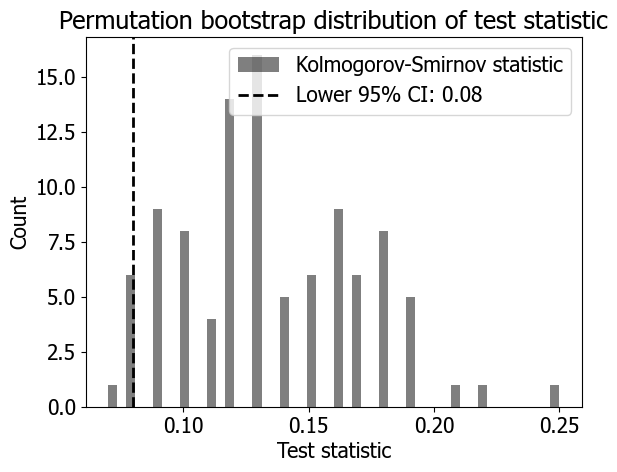

Text(0.5, 1.0, 'Permutation bootstrap distribution of test statistic')

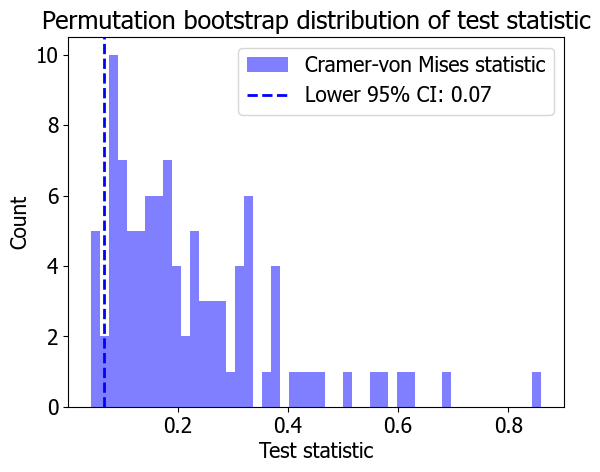

In [36]:
# Plot the test statistic histograms for CVM and KS tests

num_bins = 50

plt.hist(np.round(df.ks_stats, 6), bins = num_bins, alpha=.5, color = 'black', label = 'Kolmogorov-Smirnov statistic') # round to 5 sig figures
confidence_level = 0.05
lower_bound_quantile = ss.scoreatpercentile(df.ks_stats, confidence_level * 100)
plt.axvline(lower_bound_quantile, color='black', linestyle='--', linewidth=2, label=f'Lower 95% CI: {lower_bound_quantile:.2f}')
plt.legend()
plt.xlabel('Test statistic')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of test statistic')
plt.show()
plt.cla()

plt.hist(np.round(df.cvm_stats, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises statistic')
confidence_level = 0.05
lower_bound_quantile = ss.scoreatpercentile(df.cvm_stats, confidence_level * 100)
plt.axvline(lower_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Lower 95% CI: {lower_bound_quantile:.2f}')
plt.legend()
plt.xlabel('Test statistic')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of test statistic')


Text(0.5, 1.0, 'Permutation bootstrap distribution of p values')

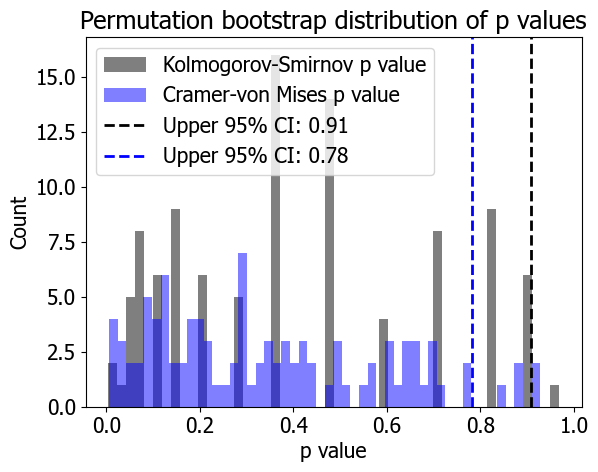

In [37]:
# Create histograms of p values; usually I observe that the CVM values are rightward shifted, indicating that more often the test does not 
# reject the null hypothesis (that the x and y samples are drawn from the same underlying distribution).
# In my opinion, this is a positive of the CVM test since it equally weights differences that appear along the entire CDF, not only the maximal difference.

plt.hist(np.round(df.ks_pvals, 6), bins = num_bins, alpha=.5, color = 'black', label = 'Kolmogorov-Smirnov p value') # round the pvalues to 5 sig figures
plt.hist(np.round(df.cvm_pvals, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises p value')

# Establish confidence intervals for the data -- if the two distributions are the same then the p-value distribution should be flat, where 5% of the time the pvalue randomly is <.05
confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(df.ks_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='black', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')

upper_bound_quantile = ss.scoreatpercentile(df.cvm_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')

plt.legend()
plt.xlabel('p value')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of p values')

Text(0.5, 1.0, 'Permutation bootstrap distribution of test statistic')

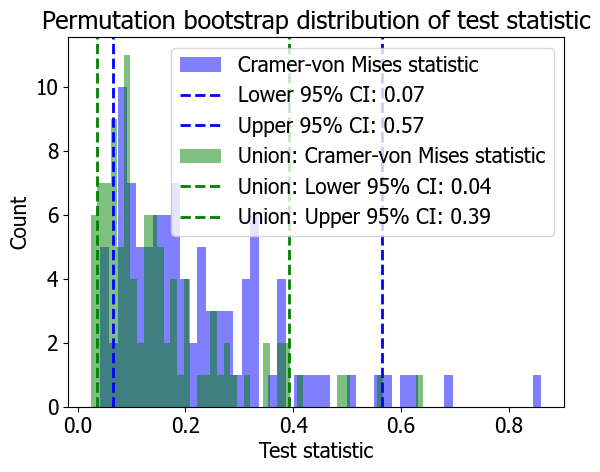

In [38]:
num_bins = 50
plt.hist(np.round(df.cvm_stats, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises statistic')

# Actual test statistic for the two full x and y datasets
#cvm_z_res = ss.cramervonmises_2samp(combined_data['WT'], combined_data['P210S'])
#true_cvm_stat = ss.cramervonmises_2samp(combined_data['WT'], combined_data['P210S']).statistic/fraction
#plt.axvline(true_cvm_stat, color='orange', linestyle='-', linewidth=2, label=f'Test statistic: {true_cvm_stat:.2f}')

# Establish confidence intervals for the data. For pvalues: If the two distributions are the same then the p-value distribution should be flat, where 5% of the time the pvalue randomly is <.05
confidence_level = 0.05
lower_bound_quantile = ss.scoreatpercentile(df.cvm_stats, confidence_level * 100)
plt.axvline(lower_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Lower 95% CI: {lower_bound_quantile:.2f}')

confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(df.cvm_stats, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')
plt.legend()

plt.xlabel('Test statistic')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of test statistic')
#plt.hist(np.round(ks_pvals, 6), bins = num_bins, alpha=.5, color = 'black', label = 'Kolmogorov-Smirnov p value') # round the pvalues to 5 sig figures
#plt.hist(np.round(cvm_pvals, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises p value')

plt.hist(np.round(df.cvm_z_stats, 6), bins = num_bins, alpha=.5, color = 'green', label = 'Union: Cramer-von Mises statistic')

# Establish confidence intervals for the data. For pvalues: If the two distributions are the same then the p-value distribution should be flat, where 5% of the time the pvalue randomly is <.05
confidence_level = 0.05
lower_bound_quantile = ss.scoreatpercentile(df.cvm_z_stats, confidence_level * 100)
plt.axvline(lower_bound_quantile, color='green', linestyle='--', linewidth=2, label=f'Union: Lower 95% CI: {lower_bound_quantile:.2f}')
confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(df.cvm_z_stats, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='green', linestyle='--', linewidth=2, label=f'Union: Upper 95% CI: {upper_bound_quantile:.2f}')

plt.legend()

plt.xlabel('Test statistic')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of test statistic')


Text(0.5, 1.0, 'Permutation bootstrap distribution of p values')

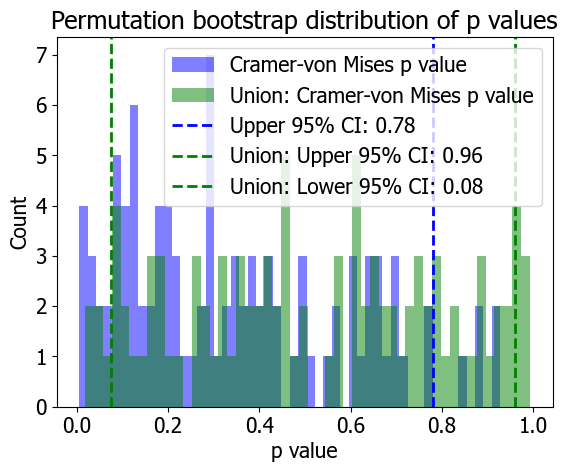

In [39]:
plt.hist(np.round(df.cvm_pvals, 6), bins = num_bins, alpha=.5, color = 'blue', label = 'Cramer-von Mises p value')
plt.hist(np.round(df.cvm_z_pvals, 6), bins = num_bins, alpha=.5, color = 'green', label = 'Union: Cramer-von Mises p value')

# Establish confidence intervals for the data -- if the two distributions are the same then the p-value distribution should be flat, where 5% of the time the pvalue randomly is <.05
confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(df.cvm_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='blue', linestyle='--', linewidth=2, label=f'Upper 95% CI: {upper_bound_quantile:.2f}')

confidence_level = 0.95
upper_bound_quantile = ss.scoreatpercentile(df.cvm_z_pvals, confidence_level * 100)
plt.axvline(upper_bound_quantile, color='green', linestyle='--', linewidth=2, label=f'Union: Upper 95% CI: {upper_bound_quantile:.2f}')
confidence_level = 0.05
lower_bound_quantile = ss.scoreatpercentile(df.cvm_z_pvals, confidence_level * 100)
plt.axvline(lower_bound_quantile, color='green', linestyle='--', linewidth=2, label=f'Union: Lower 95% CI: {lower_bound_quantile:.2f}')



plt.legend()
plt.xlabel('p value')
plt.ylabel('Count')
plt.title('Permutation bootstrap distribution of p values')

First we investigate autocorrelation in our x dataset


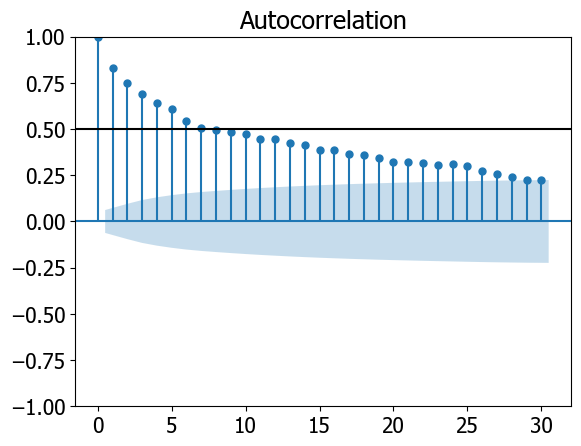

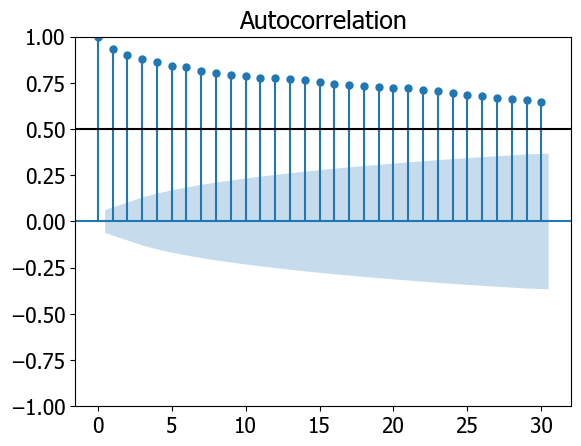

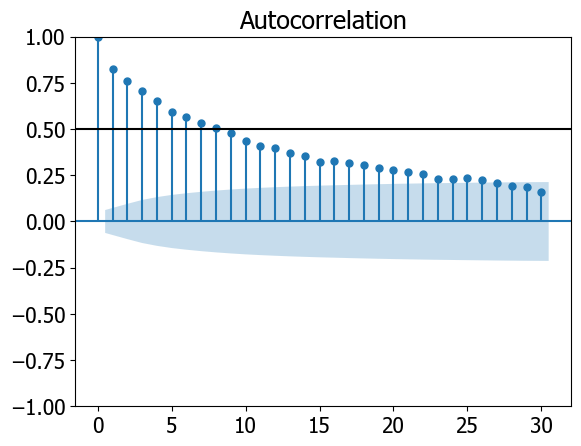

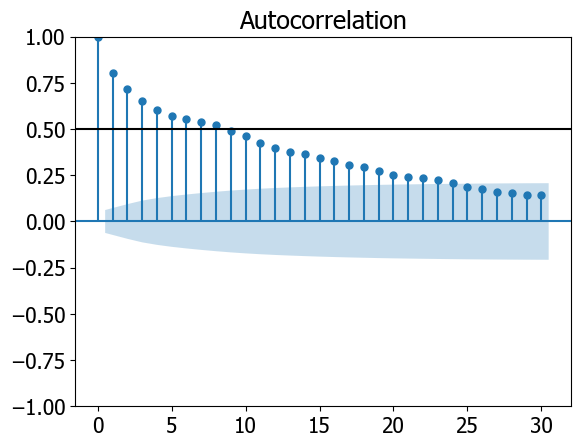

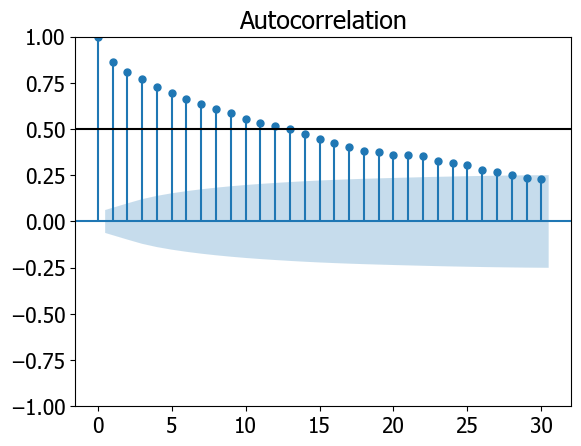

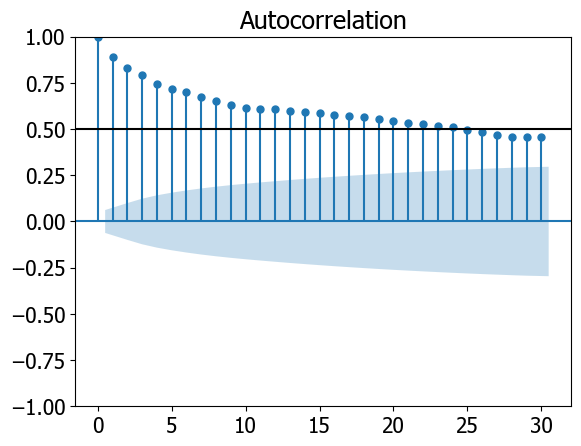

In [10]:
# Finally, at the beginning we asked about autocorrelation. What are the differences in autocorrelation for our boots? 
shifts = [0, 5000, 10000, 15000, 20000, 25000] # Take n long samples every 5,000 points to get an understanding for how autocorrelation varies along the signal
# The reason for using only n datapoints is because that is the size of our boots.

print('First we investigate autocorrelation in our x dataset')
for i in shifts:
    sm.graphics.tsa.plot_acf(x[i:i+n], lags=30) 
    plt.axhline(.5, c = 'black')

Then we investigate autocorrelation in our y dataset


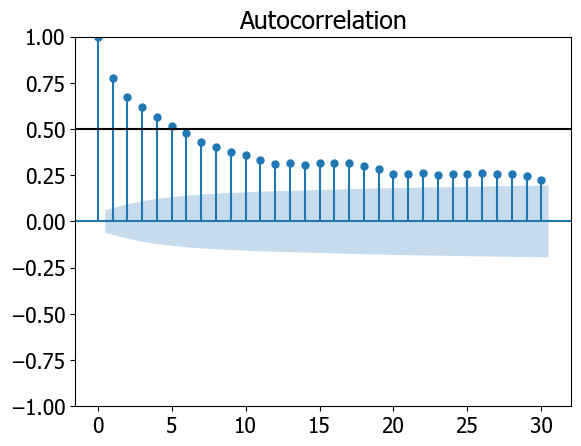

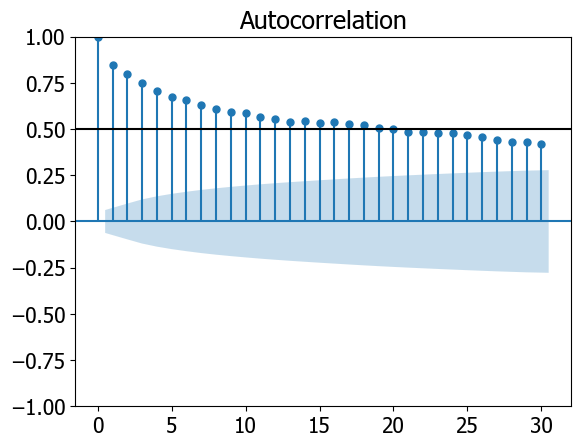

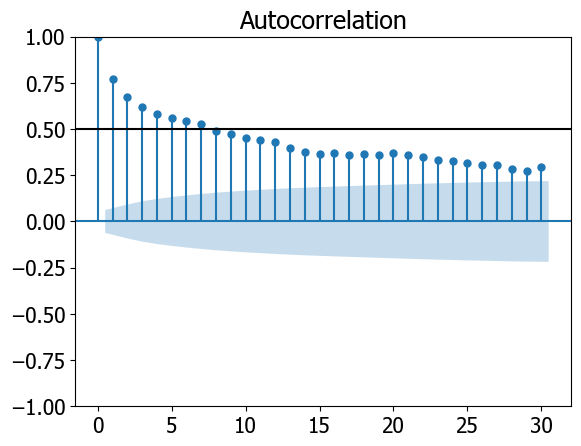

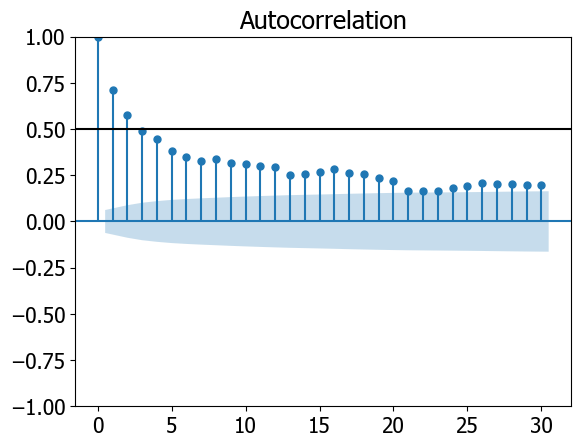

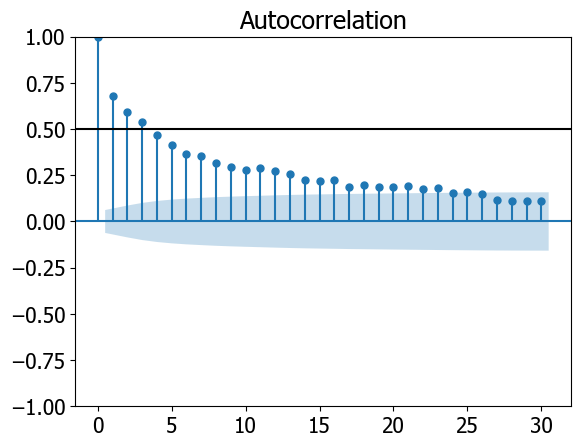

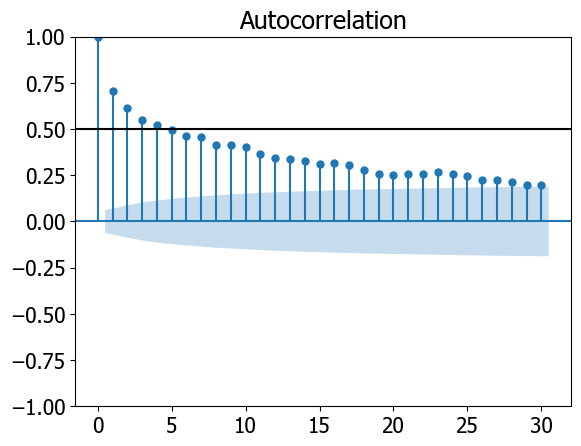

In [167]:
print('Then we investigate autocorrelation in our y dataset')
for i in shifts:
    sm.graphics.tsa.plot_acf(y[i:i+n], lags=30) 
    plt.axhline(.5, c = 'black')

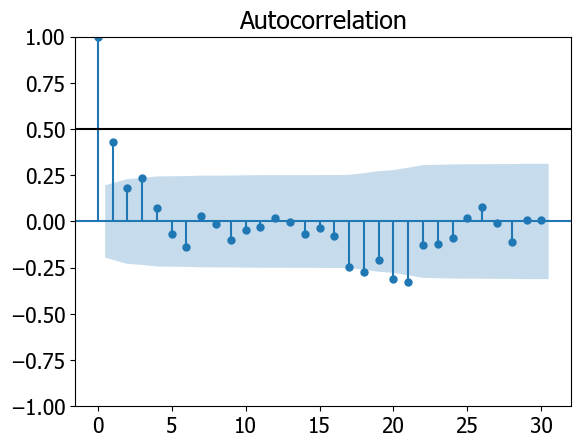

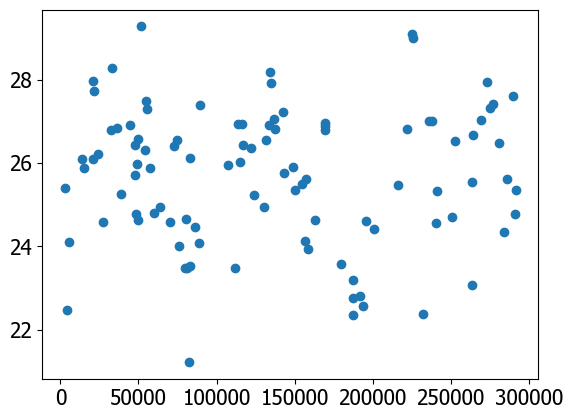

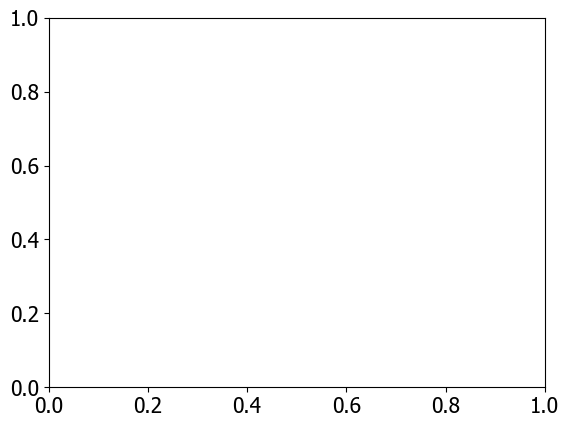

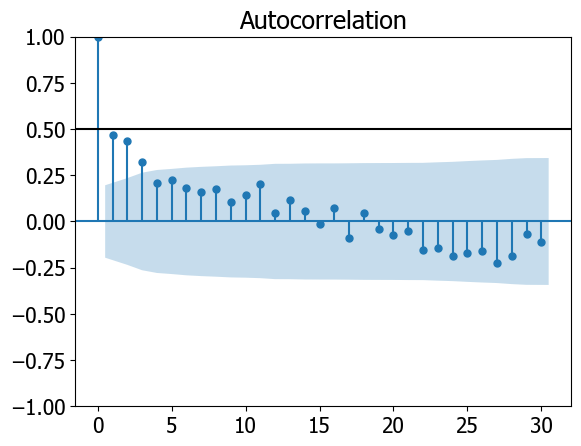

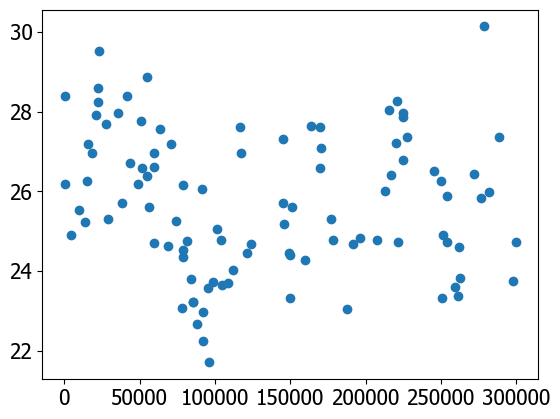

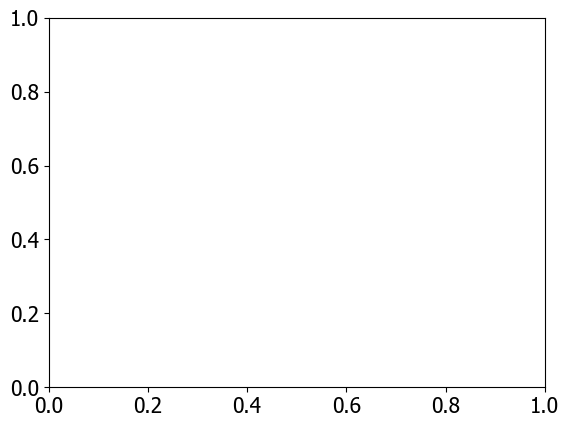

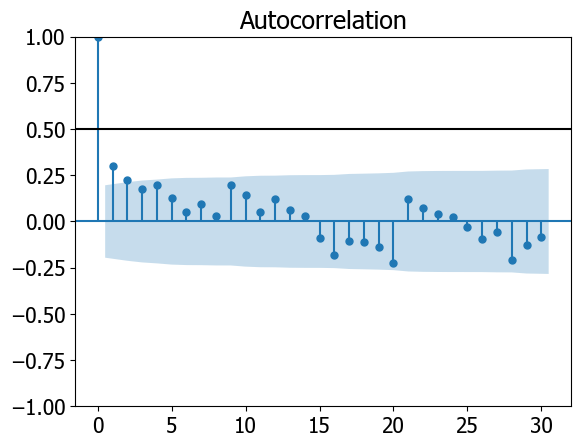

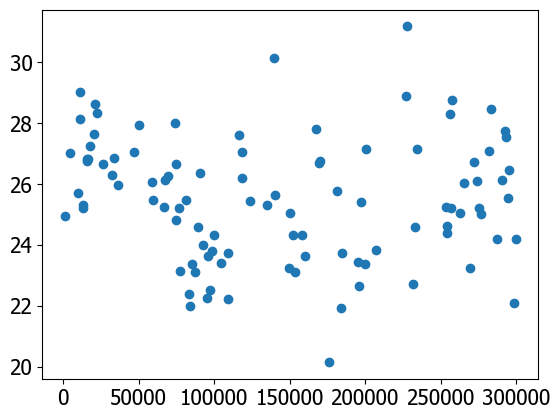

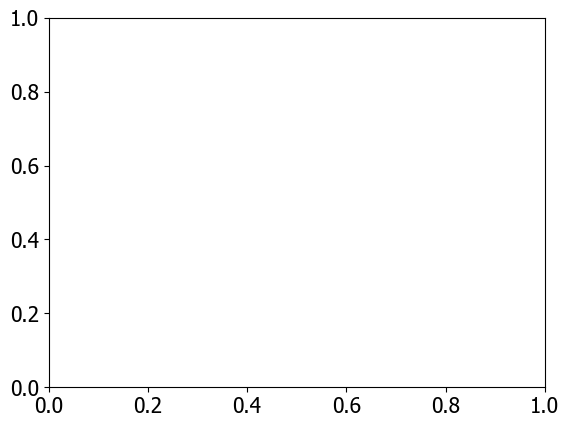

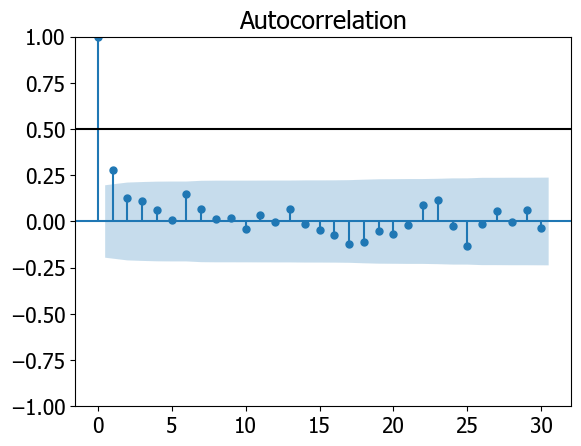

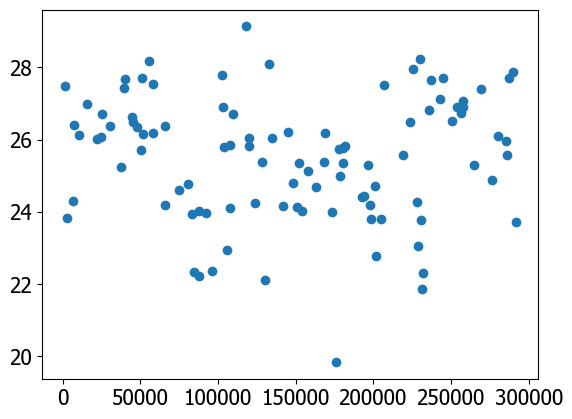

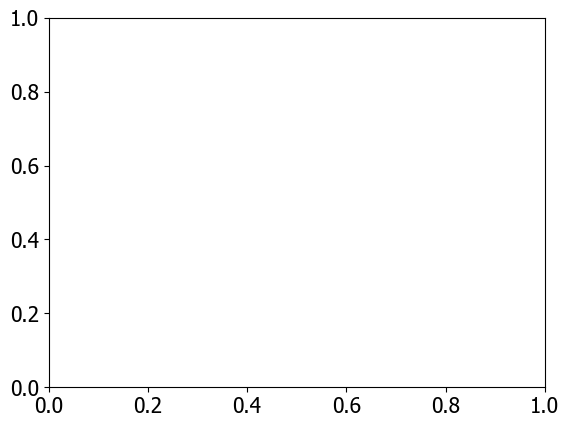

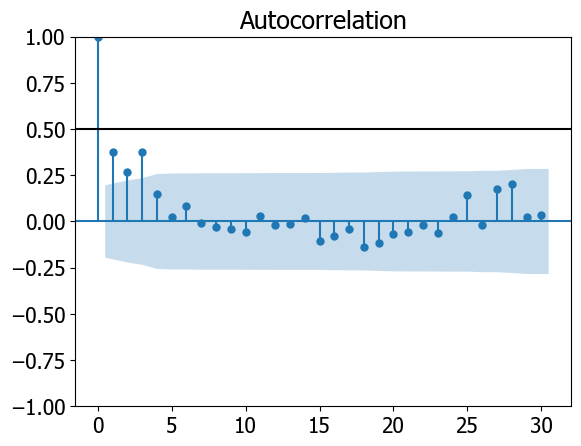

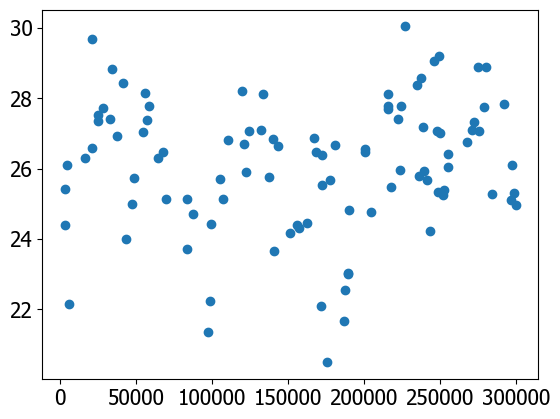

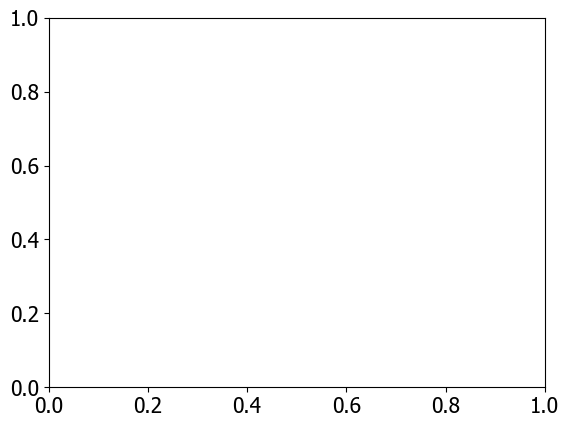

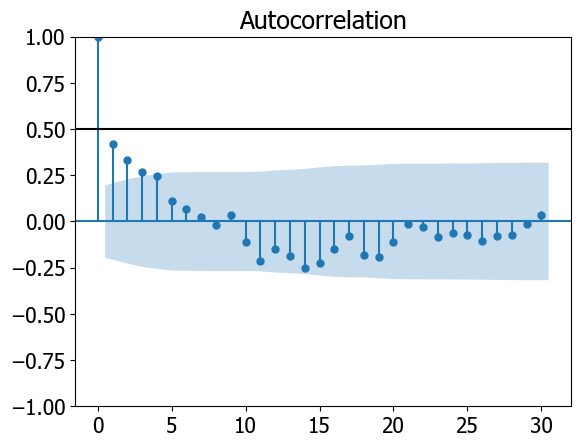

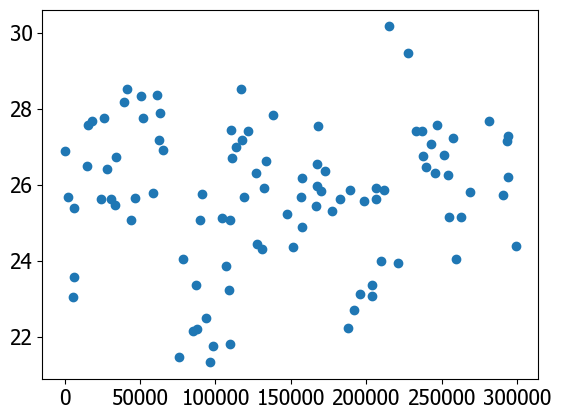

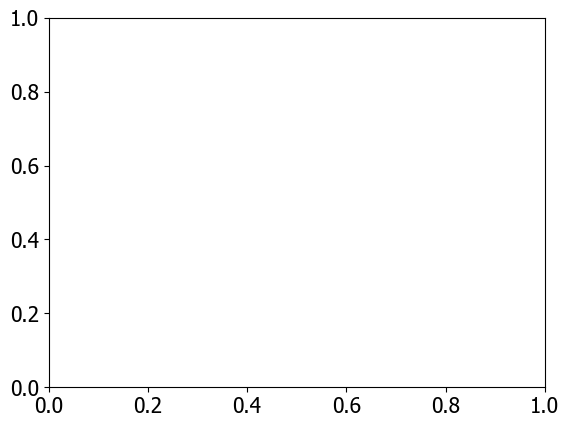

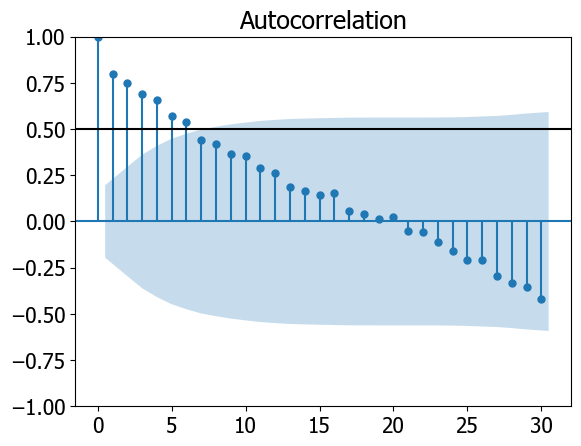

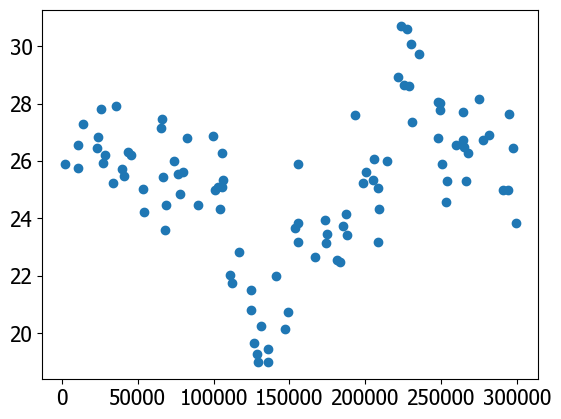

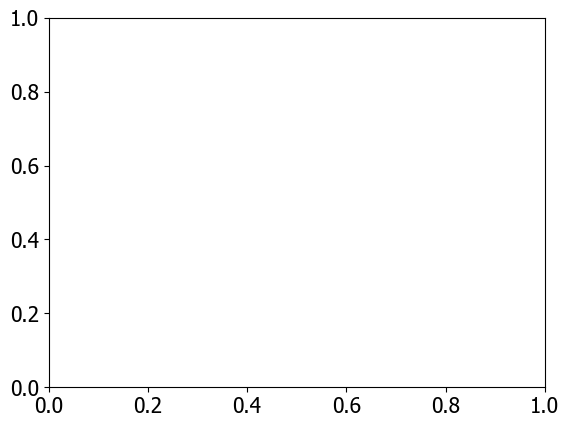

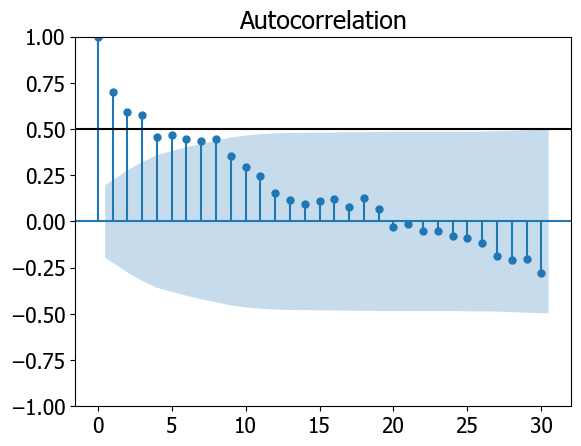

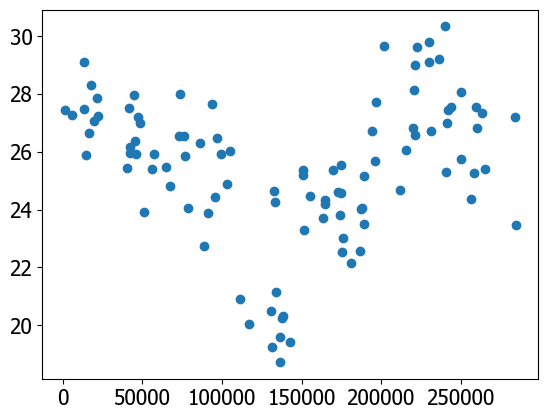

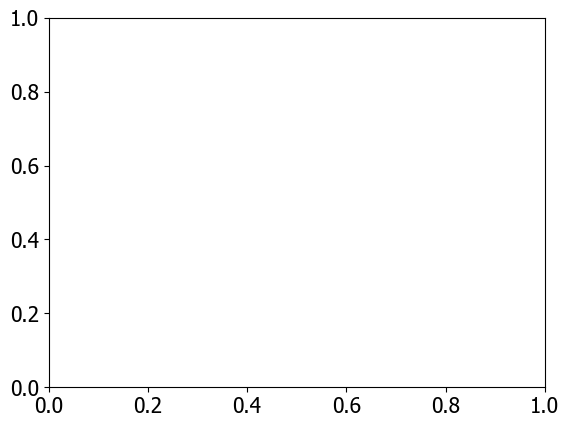

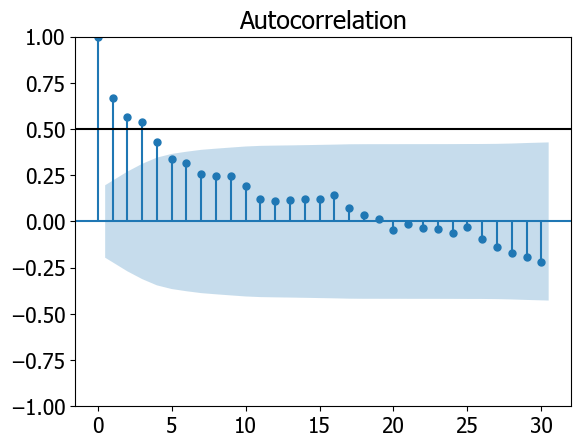

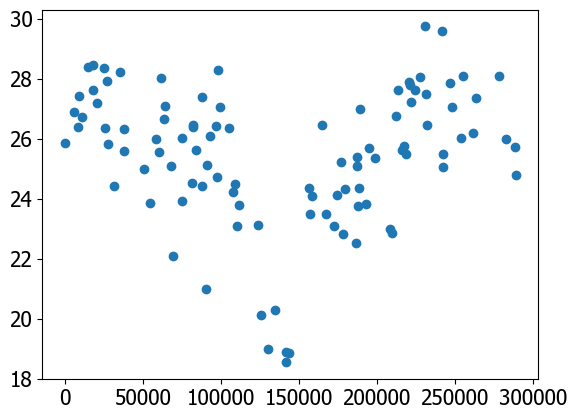

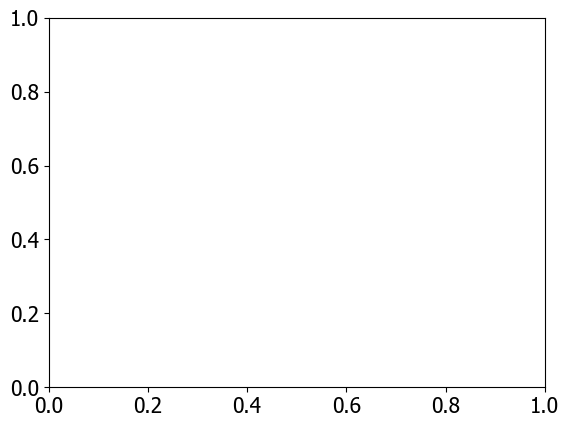

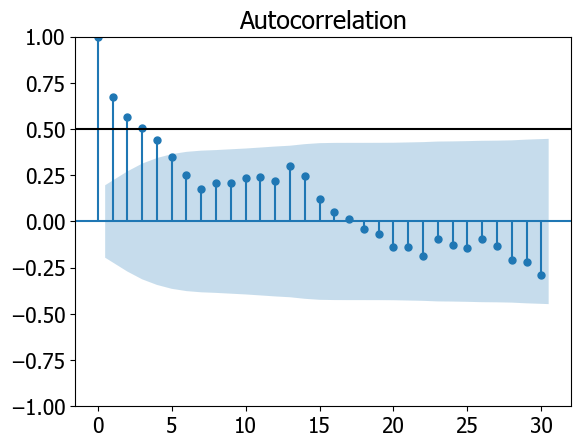

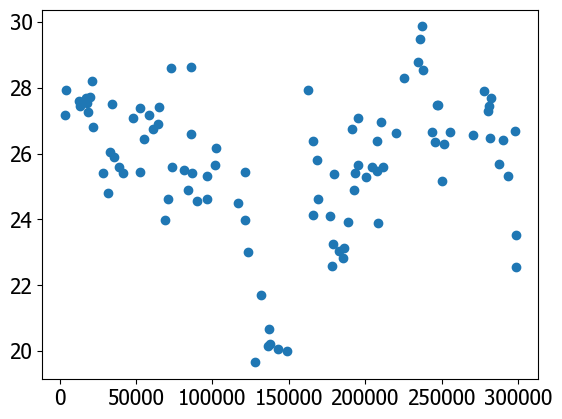

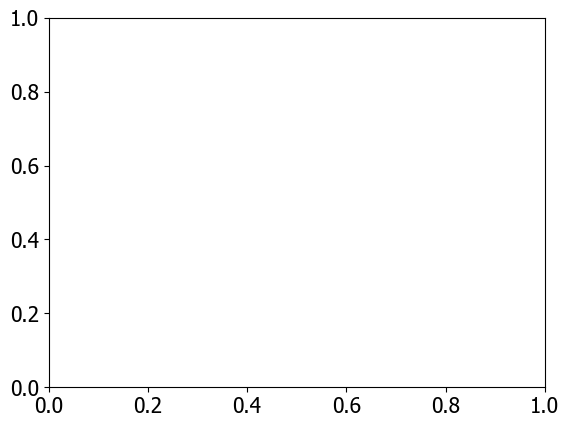

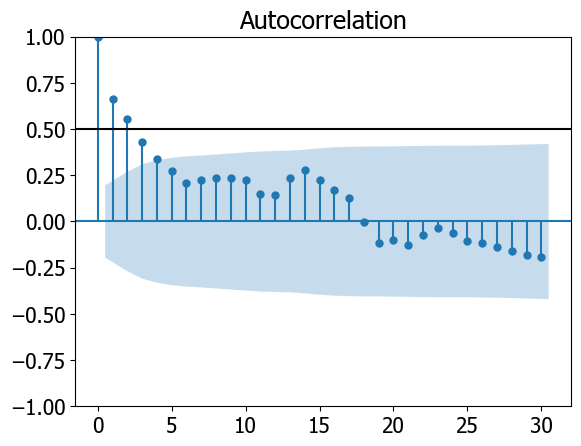

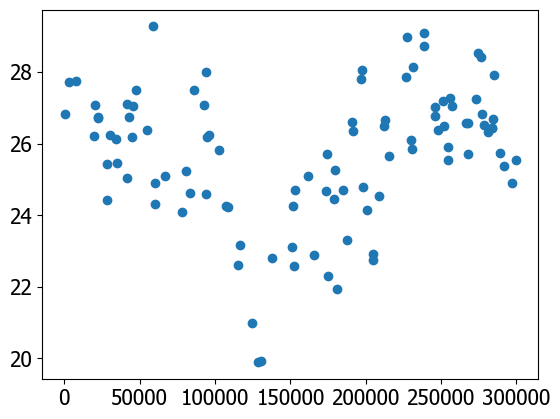

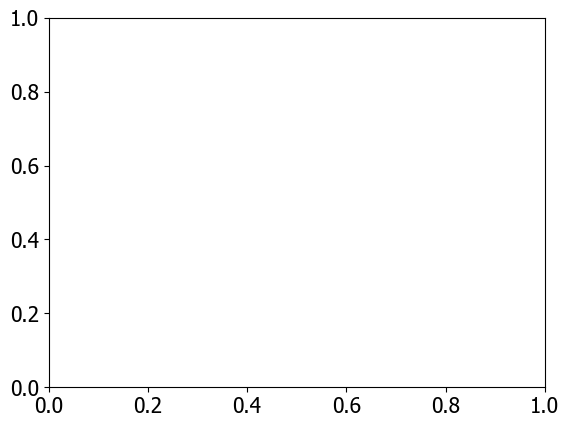

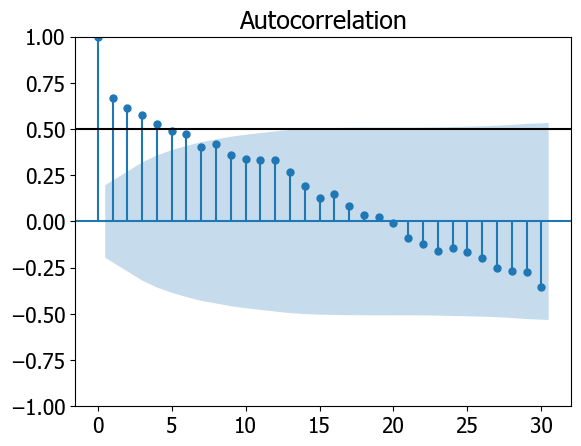

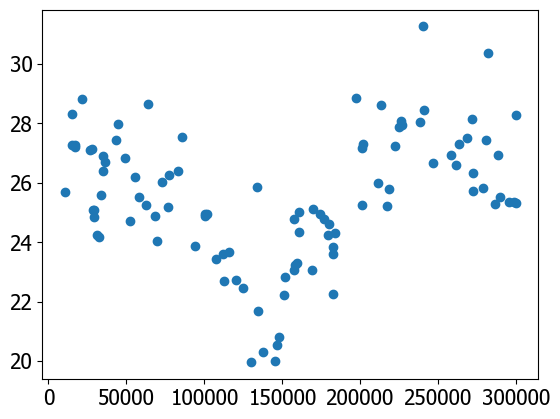

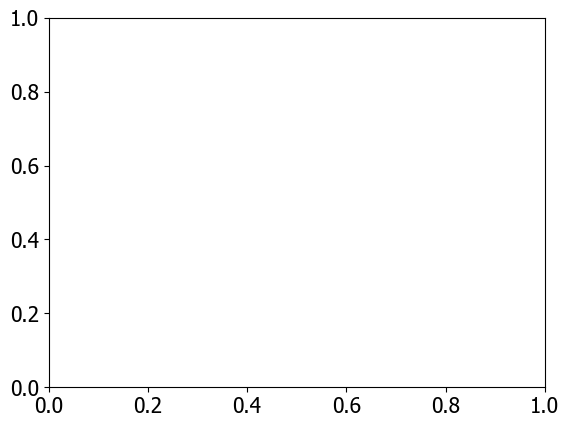

In [40]:
# Need to look at the autocorrelations of the bootstraps, but this is complicated because we have to correctly order the timeseries data.
# This is where my use of x and y breaks down, so if dealing with a different dataset this will need to be adapted to that data. 
n = 100

combined_data_df = pd.DataFrame()
combined_data_df['WT'] = combined_data['WT']
combined_data_df['P210S'] = combined_data['P210S']

for i in np.arange(0,len(shifts)):
    boot_index = np.sort(resample(combined_data_df.index.values, replace=True, n_samples=n))
    sm.graphics.tsa.plot_acf(combined_data_df.WT.iloc[boot_index], lags=30) 
    plt.axhline(.5, c = 'black')
    plt.show()
    plt.cla()
    plt.scatter(boot_index, combined_data_df.WT.iloc[boot_index])
    plt.show()
    plt.cla()


combined_data_df.index.values

for i in np.arange(0,len(shifts)):
    boot_index = np.sort(resample(combined_data_df.index.values, replace=True, n_samples=n))
    sm.graphics.tsa.plot_acf(combined_data_df.P210S.iloc[boot_index], lags=30) 
    plt.axhline(.5, c = 'black')
    plt.show()
    plt.cla()
    plt.scatter(boot_index, combined_data_df.P210S.iloc[boot_index])
    plt.show()
    plt.cla()
    